# Unsupervised Machine Learning for Facies Predictions

This tutorial will be the first in a series aimed at Geoscientists in the mining and petroleum industries.  My objective is to show that a combination of domain expertise and some basic coding ability can result in a powerful set of skills that will greatly enhance geo-scientific data analysis.  The ability to process, manipulate and draw insight from large datasets has always been necessary in geosciences, however, as data velocity, variety and volume in the field continues to increase, the skills of a Data Scientist are increasingly relevant.

In this post, Im going to demonstrate a method for combining dimensionality reduction with unsupervised machine learning in order to attempt to out-perform lithology classifications from cuttings descriptions.  Cuttings descriptions are important for geoscientists as they often provide the only continuous representation of real rock information from a well or drill-hole.  However, these are notoriously poor data sources which can suffer from error such as caving.  Furthermore, the interpretation of cuttings are highly subjective and can differ between well-site geologists.  Conventional drill-core offers the most accurate representation of the rock record, however, it is often incomplete or not collected at all. 

Wireline log data is a powerful, high dimension dataset that offers almost continuous representation of lithofacies and fluid properties in the sub-surface.  If collected properly it offers a consistent and high resolution dataset, that is unbiased by subjective interpretation.  In this post, Im going to show how wireline data can be used to classify lithofacies, without prior interpretation. 

## Datasets
A Las file containing wireline log data, csv of Cuttings Descriptions and Well Completion report for Roc-1 exploration well were all downloaded from the Australian government's open source petroleum well database; https://www.ga.gov.au/nopims.

Some minor editing of the csv Cuttings Descriptions and wireline Data has been conducted so that they could be used in this project.    

In [2]:
import sys
import os
sys.path.insert(0, r'd:\Working Folder\Perosnal Projects\Unsupervised_Facies_Prediction_WirelineLogs')
os.chdir(sys.path[0])

In [3]:
import plotly.io as pio
pio.renderers.default = "notebook"

# Import libraries
Before getting started, we must import the required python libraries.  All packages that I will use during this tutorial are off the shelf python implementations.  

In [4]:
# Import the required libraries
import matplotlib.pyplot as plt
import lasio
import pandas as pd 
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import umap as umap
from sklearn.cluster import SpectralClustering
import plotly.express as px
import plotly.graph_objects as go

d:\Working Folder\Perosnal Projects\Unsupervised_Facies_Prediction_WirelineLogs\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [5]:
# Use Lasio to Import the Las file for Roc-1
Roc_1_logs = lasio.read('data/Roc-1_S1R1_SP-HRLA-PEX-GR_Main.las')

# Import cuttings interpretations for Roc-1  
Roc_1_lith = pd.read_csv('data/Roc-1_Lith.csv')

# Show the first 5 rows of the Cuttings Interpretations
Roc_1_lith.head()

,Depth,Depth to,Lithofacies
0,1330.00,1341.00,Void
1,1341.00,1370.00,Clay-shale
2,1370.00,1376.57,Clay-shale
3,1376.57,1378.43,Glauconitic sandstone
4,1378.43,1382.05,Clay-shale


## Clean up the Wireline Data
For this experiment we intend to use three logs found in the las file including; Gamma Ray (GR), TNPH and RHOZ.  The Gamma Ray measures the natural radioactivity of a formation and offers a powerful method for discriminating lithofacies.  Shales emit high gamma radiation because they often contain abundant potassium compared with compositionally mature sands or limestones that emit much lower gamma radiation.  TNPH is a thermal neutron log that measures neutron porosity within a formation, and RHOZ provides a measure of formation density.  Together all three logs provide ideal variables for distinguishing between different rock types in the sub-surface.         

Before using the data, we have to make sure it is of high enough quality, otherwise any results are unlikely to make geological sense.  This is where domain knowledge is important.  We can plot a histogram of the Density values from the RHOZ log and look for outliers.  As can be seen below, there are some anomalously high values that are unlikely to be real.  Fortunately python makes it easy to clean up the data.  

In [6]:
# Create a dataframe for Roc 1 with the relevant logs
Roc_1 = pd.DataFrame()
Roc_1['Depth'] = Roc_1_logs['DEPT']
Roc_1['GR'] = Roc_1_logs['GR:1']
Roc_1['TNPH'] = Roc_1_logs['TNPH:1']
Roc_1['RHOZ'] = Roc_1_logs['RHOZ']

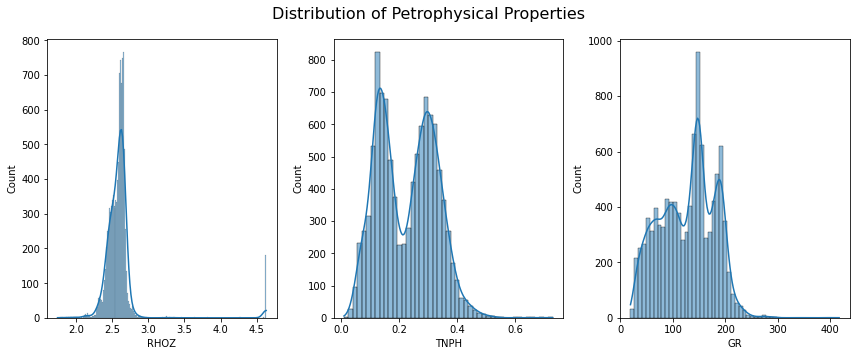

In [7]:
# Show distribution of petrophysical properties from imported logs
fig, axes = plt.subplots(1, 3, figsize=(12,5))
fig.suptitle('Distribution of Petrophysical Properties', fontsize=16)

#create boxplot in each subplot
sns.histplot(Roc_1['RHOZ'], kde= True, ax=axes[0])
sns.histplot(Roc_1['TNPH'], kde= True, ax=axes[1])
sns.histplot(Roc_1['GR'], kde= True, ax=axes[2])

fig.tight_layout()

### Filter the data
To de-spike the density log, we can easily replace values of over 2.9 g/cm3 with the average of all the density data.  This will provide a clean version of the variable without the need to remove data.  

The Roc-1 exploration well was drilled to a total depth of over 5000m.  However, in order to target a zone that includes a potential reservoir and seal, we are going to filter the dataset to all data deeper than 4200m.

In [8]:
# Clean up the Roc 1 density log
avg = Roc_1['RHOZ'].mean()
Roc_1['RHOZ'] = Roc_1['RHOZ'].apply(lambda v: avg if v > 2.9 else v)

# Drop any row in Roc 1 Dataframe with a NaaN value
Roc_1 = Roc_1.dropna()

# Filter data for records below 4200m
Roc_1 = Roc_1[Roc_1['Depth'] > 4200]
Roc_1_lith = Roc_1_lith[Roc_1_lith['Depth'] > 4200]

# Reset index of dataframes
Roc_1 = Roc_1.reset_index(drop=True)
Roc_1_lith = Roc_1_lith.reset_index(drop=True)

## Attach the Cuttings interpretation to the Wireline data.    
In order to visualise the cuttings descriptions alongside the Wireline logs, we need to do some data preparation.  The cuttings interpretations have to be appended to the dataframe containing wireline data.  However, the cuttings are discrete records with different sample depths.  We can use the pandas library 'merge_asof' to merge the two datasets and assign the nearest depth value from the Wireline data, to that of the cuttings.  Then we can append these to the original wireline dataframe and either back fill or forward fill null cuttings entries so that we have a complete dataframe to work with.  

In [9]:
# Attach Lithofacies data to Log Data
to_merge = pd.DataFrame()
to_merge['Lithofacies'] = Roc_1_lith['Lithofacies']
to_merge['Depth'] = Roc_1_lith['Depth']
to_merge = to_merge.sort_values(by=['Depth'])

merge = pd.merge_asof(to_merge, Roc_1, on='Depth', direction = "nearest")

# Add rows to dataframe
merge2 = pd.concat([Roc_1, merge], ignore_index=True)
merge2 = merge2.sort_values(by=['Depth'])

# forward fill Lithofacies
merge2['Lithofacies'] = merge2['Lithofacies'].fillna(method = 'ffill')
merge2['Lithofacies'] = merge2['Lithofacies'].fillna(method = 'bfill')

merge2.head()

,Depth,GR,TNPH,RHOZ,Lithofacies
0,4200.1440,146.9561,0.33659,2.60834,Siltstone
1,4200.2964,146.2662,0.33355,2.57906,Siltstone
2,4200.4488,150.0880,0.32825,2.51519,Siltstone
3,4200.6012,155.0461,0.34255,2.43345,Siltstone
4,4200.7536,151.4537,0.35468,2.36316,Siltstone


# Implement Umap Data Dimensionality Reduction
Finally, we are in a position to implement a data reduction technique and visualise the interpretation of the cuttings descriptions in reduced dimensions.  For this, we are going to apply a technique known as Uniform Manifold Approximation and Projection (UMAP) first described by McInnes et al. (2018).  This is a powerful dimension reduction technique that constructs an initial high dimension graph layout of the data before re-projecting a structurally consistent low dimension form (Coenen & Pearce n.d. Google PAIR).  Unlike Principal Component Analysis (PCA), UMAP can handle non-linear relationships, and it has also been shown to be computationally more efficient than t-SNE. 

The two most important parameters for UMAP are 'n_neighbors' and 'min_dist' (UMAP Docs n.d.).  The n_neighbors parameter prescribes the number of nearest neighbors of each data point that is used to construct the initial graph layout.  This parameter controls the balance between global and local structure with low values allowing scrutiny of local neighborhoods and higher values providing a representation of broad structure. The min_dist parameter prescribes the minimum distance between data points in low dimension space and therefore controls the degree of clustering observed in the final result.   

A best practice approach would be to iterate on these parameters until an acceptable balance between broad and local structure was found, but for this example we will invoke the defaults.    

Since we have only three logs that we intend to involve as variables, the dataset does not suffer from high dimensionality.  However the relationship between these variables is complex, non-linear and it is always difficult to comprehend how multiple petrophysical responses can reflect changes to lithofacies or fluid content in the sub-surface.

In [10]:
# Prepare the input variables and scale the data
X = merge2.drop(['Depth', 'Lithofacies'], axis=1)

# Use Z Score Scaling for numerical variables
scaled = X.copy()
zscore = StandardScaler()
scaled[['GR','TNPH','RHOZ']] = zscore.fit_transform(scaled[['GR','TNPH','RHOZ']])

scaled.head()

,GR,TNPH,RHOZ
0,-0.224961,0.772091,-0.287721
1,-0.239062,0.742382,-0.699609
2,-0.160944,0.690587,-1.598081
3,-0.059598,0.830335,-2.747934
4,-0.133028,0.948877,-3.736718


In [11]:
# Implement UMAP dimension reduction
dred = umap.UMAP(n_neighbors = 15, min_dist = 0.1, n_components=2, random_state=0).fit(scaled)
umap1 = pd.DataFrame(columns = ['Cp1','Cp2'])
umap1['Cp1'] = dred.embedding_[:, 0] 
umap1['Cp2'] = dred.embedding_[:, 1]
umap1['Cuttings'] = merge2['Lithofacies']

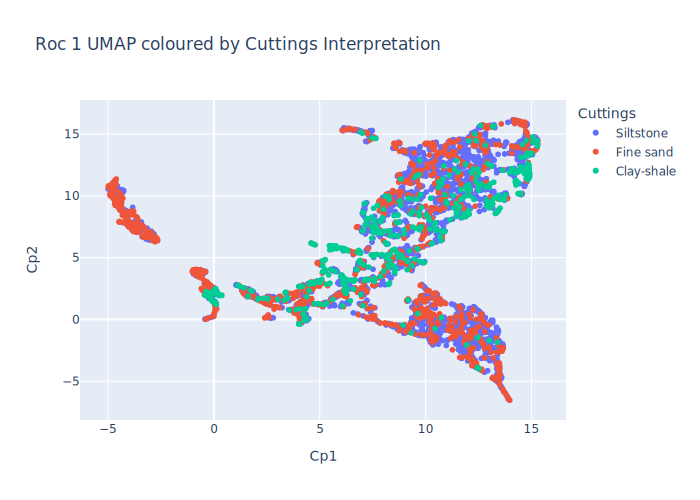

In [12]:
# Visualise the Roc 1 UMAP, coloured by Cuttings Interpretation
fig = px.scatter(umap1, x="Cp1", y="Cp2", color="Cuttings", 
title = 'Roc 1 UMAP coloured by Cuttings Interpretation')
fig.show(renderer="svg")
fig.write_html("outputs/Umap_Cuttings.html")

# Implement Unsupervised Learning
As can be seen in the figure above, the two dimensional UMAP space clearly distinguishes a series of groups that presumably have similar petrophysical properties.  However, when coloured by Cuttings Interpretation, it seems that the three lithology classes are spread across the groups, implying that the well-site geologist has not captured these differences.  This highlights a pit-fall of logging rock types based on colour and without the textural context that conventionally cut drill-core provides.  It also shows that visual logging can fail to detect subtle differences in physical rock properties that might be useful during reservoir modelling, or rock physics and inversion studies.    

For the next step in this post, we shall test whether an unsupervised machine learning method known as Spectral Clustering does a better job of representing each of the observed petrophysical domains that are implied by the UMAP representation.  

Spectral Clustering works well for a range of different cluster shapes, such as those observed in the 2D UMAP visualisation shown above.  This is because the algorithm uses a connectivity approach to classify data points, meaning that data are more likely to be grouped when they are either touching or directly adjacent to one another (Keerthana 2021, Analytics Vidhya).  This differs to distance based clustering techniques such as kmeans which rely on computing the distance of data points from randomly assigned centroids.  

In the example below we use the embeddings calculated by the UMAP dimension reduction as input for the clustering algorithm.  

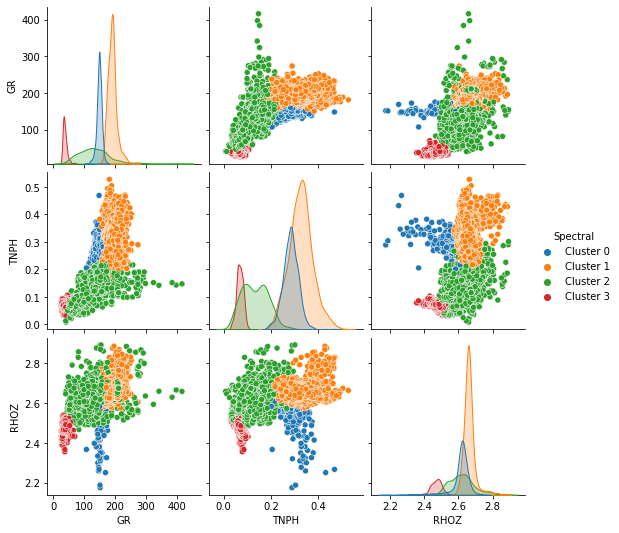

In [13]:
# Fit Spectral Clustering to the dataset
umap_input = umap1.drop(['Cuttings'], axis=1) 
Spectral = SpectralClustering(n_clusters = 4, random_state= 0)
y_Spec = Spectral.fit_predict(umap_input)

# Append predictions back to the dataframe
umap1['Spectral'] = y_Spec
merge2['Spectral'] = y_Spec

# Visualise the Roc 1 UMAP, coloured by Predictions
encode = {0 : "Cluster 0", 1: "Cluster 1", 2: "Cluster 2", 3 : "Cluster 3"}
umap1['Spectral'] = umap1['Spectral'].replace(encode)
merge2['Spectral'] = merge2['Spectral'].replace(encode)

# Visualise Petrophysical characteristics of clusters
sns.pairplot(merge2.drop('Depth',axis=1),
             hue='Spectral', palette= 'tab10')  
plt.show()


As can be seen in the pairplot above, the clusters each capture unique petrophysical domains.  Cluster 2 has gamma ray values of generally lower than 200, normally distributed RHOZ values of ~2.5-2.8 g/cm3 and Neutron Porosity characteristic of brine filled sediments buried to more than 3000m.  Cluster 0 also has low GR, but comparatively higher TNPH indicating reasonable quality sands.  Cluster 1 has gamma ray values of over 200, generally much higher RHOZ values and is probably representative of claystone.  Perhaps the most interesting is Cluster 3 which is made up of the fewest data points and characterised by low gamma ray indicative of the most mature and clean sands in the dataset.  However, it also hosts the lowest density and neutron porosity, suggesting that these sands may also host hydrocarbon.  

# Visualise the Spectral Clustering resulting in UMAP space

As can be seen below, by colouring the data points in UMAP space by the Spectral Clustering labels, it is clear that the main petrophysical domains have been captured.  The method has out-performed the Cuttings Interpretation as far as identifying unique rock properties in the well.  

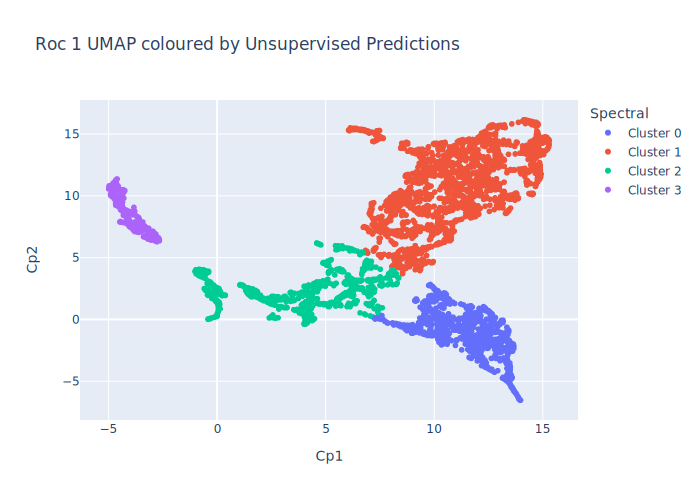

In [14]:
umap1['Spectral'] = umap1['Spectral'].astype(str)
fig = px.scatter(umap1, x="Cp1", y="Cp2", color="Spectral", 
title = 'Roc 1 UMAP coloured by Unsupervised Predictions')
fig.show(renderer="svg")
fig.write_html("outputs/Clustered_UMAP.html")

# Visualise a Strip Log to compare the Cuttings Interpretations with the Predicted Classes
For the final section in this tutorial we shall visualise the cuttings interpretation and compare with the predicted petrophysical classes generated by dimension reduction and Spectral Clustering.  We will view these alongside a Gamma Ray log to provide some geological context.  

We can write a function that can plot a log alongside a series of discrete classes and specify the start and end depths that we would like to inspect.   

['Cluster 0' 'Cluster 1' 'Cluster 2' 'Cluster 3']


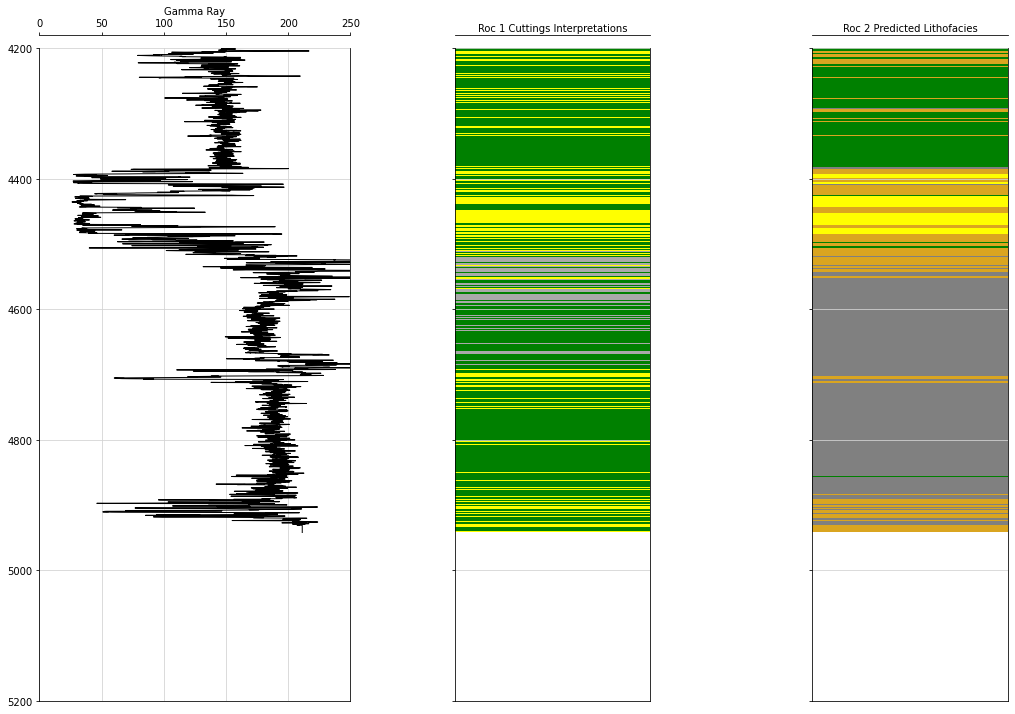

In [15]:
# visualise strip log of Logs and cuttings interpretation for Roc 1
print(merge2['Spectral'].unique())

# Compare the results of clustering and cuttings interp
d1 = {' Siltstone': 1, ' Fine sand': 2, ' Clay-shale': 3}
colors1 = ['green', 'yellow','darkgrey']
cmap1 = ListedColormap(colors1)

d2 = {"Cluster 0": 1, "Cluster 1": 2, "Cluster 2": 3, "Cluster 3" : 4}
colors2 = ['green', 'grey','goldenrod', 'yellow']
cmap2 = ListedColormap(colors2)

def Roc_1_striplog(merge2, bottom_depth, top_depth):
    fig, ax = plt.subplots(figsize=(15,10))

    #Set up the plot axes
    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # Roc 1 Gamma Ray Track
    ax1.plot(merge2["GR"], merge2['Depth'], color = "black", linewidth = 1.0)
    ax1.set_xlabel("Gamma Ray")
    ax1.set_xlim(0, 250)
    ax1.xaxis.label.set_color("black")
    ax1.tick_params(axis='x', colors="black")
    ax1.spines["top"].set_edgecolor("black")
    ax1.set_xticks([0, 50, 100, 150, 200, 250])

    # Roc 1 Cuttings Interpretation
    ax2.pcolormesh([-1, 2], merge2['Depth'], merge2['Lithofacies'][:-1].map(d1).to_numpy().reshape(-1, 1),
              cmap=cmap1, vmin=1, vmax=len(colors1))
    ax2.set_xticks([])
    ax2.set_aspect(0.01)
    ax2.set_xlabel("Roc 1 Cuttings Interpretations")

    # Roc 1 Predictions
    ax3.pcolormesh([-1, 2], merge2['Depth'], merge2['Spectral'][:-1].map(d2).to_numpy().reshape(-1, 1),
              cmap=cmap2, vmin=1, vmax=len(colors2))
    ax3.set_xticks([])
    ax3.set_aspect(0.01)
    ax3.set_xlabel("Roc 2 Predicted Lithofacies")

    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
        
    for ax in [ax2, ax3]:
        plt.setp(ax.get_yticklabels(), visible = False)
       
    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)

Roc_1_striplog(merge2, 5200, 4200)
plt.show()

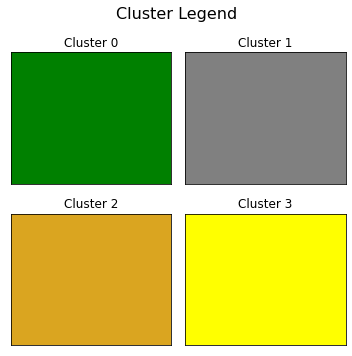

In [16]:
# Generate a legend for the clusters
facies = {0: {'lith':'Cluster 0', 'lith_num': 0, 'hatch': '', 'color':'green'},
                 1: {'lith':'Cluster 1', 'lith_num':1, 'hatch':'', 'color':'grey'},
                 2: {'lith':'Cluster 2', 'lith_num':2, 'hatch':'', 'color':'goldenrod'},
                 3: {'lith':'Cluster 3', 'lith_num':3, 'hatch':'', 'color':'yellow'}}

y = [0, 1]
x = [1, 1]

fig, axes = plt.subplots(ncols=2,nrows=2, sharex=True, sharey=True,
                         figsize=(5,5), subplot_kw={'xticks': [], 'yticks': []})
fig.suptitle('Cluster Legend', fontsize=16)                         

for ax, key in zip(axes.flat, facies.keys()):
    ax.plot(x, y)
    ax.fill_betweenx(y, 0, 1, facecolor=facies[key]['color'], hatch=facies[key]['hatch'])
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 1)
    ax.set_title(str(facies[key]['lith']))

plt.tight_layout()
plt.show()

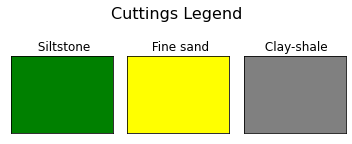

In [17]:
# Generate a legend for the Cuttings Interpretations
facies = {0: {'lith':' Siltstone', 'lith_num': 0, 'hatch': '', 'color':'green'},
                 1: {'lith':' Fine sand', 'lith_num':1, 'hatch':'', 'color':'yellow'},
                 2: {'lith':' Clay-shale', 'lith_num':2, 'hatch':'', 'color':'grey'}}

y = [0, 1]
x = [1, 1]

fig, axes = plt.subplots(ncols=3,nrows=1, sharex=True, sharey=True,
                         figsize=(5,2), subplot_kw={'xticks': [], 'yticks': []})
fig.suptitle('Cuttings Legend', fontsize=16)

for ax, key in zip(axes.flat, facies.keys()):
    ax.plot(x, y)
    ax.fill_betweenx(y, 0, 1, facecolor=facies[key]['color'], hatch=facies[key]['hatch'])
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 1)
    ax.set_title(str(facies[key]['lith']))

plt.tight_layout()
plt.show()

The predicted classes clearly provide more granularity and appear to be geologically reasonable.  The cuttings interpretation imply that high gamma zones between ~4200-4400m are the same lithofacies as those between ~4500m -TD.  However, the predicted classes discriminate between these, and this is likely to be more accurate since the gamma ray is generally much higher for the deeper interval.  The predicted classes also seem to discriminate between sand end members.  Cluster 3 is coloured in yellow and as mentioned earlier, these exhibit a potential hydrocarbon response from the logs. 

Of course, the true test of this approach is to compare the results with real rock information.  There is no conventional core for Roc-1, so we need to compare our results with available Side Wall Core (SWC) information.  Since the cuttings and predicted classes mostly agree for the reservoir interval (~4390-4500m), we aren't going to investigate that section further.  Instead, lets compare the results of the two main fine grained packages mentioned earlier with SWC photos and descriptions provided in the Roc-1 Well Completion Report.  

SWC sample R11-C10, was recovered from 4299.12m.  According to the photos and descriptions below it represents a Mudstone with rare mica and 'red and black heavy minerals or organic matter.'  This is far from a Siltstone interpreted from the Cuttings descriptions.  Sample R11-C27 was recovered from 4607.76m and apparently represents a black mudstone with some bioturbation and diagenetic pyrite.  This might suggest an initially sub-oxic to oxic ocean floor depositional space that later deepened to become stratified.  More importantly it is a different facies to the previous sample and validates the discriminations made by Dimension Reduction and Spectral clustering.       

![Screenshot](SWC.png)

# References
Coenen & Pearce n.d. Google PAIR, Understanding UMAP https://pair-code.github.io/understanding-umap/

Keerthana V. (2021), Analytics Vidhya, What, why and how of Spectral Clustering, https://www.analyticsvidhya.com/blog/2021/05/
what-why-and-how-of-spectral-clustering/

McInnes L., Healy J., Melville J. (2018), UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, 	arXiv:1802.03426 

UMAP Docs n.d., UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, https://umap-learn.readthedocs.io/en/latest/index.html

